# Importing needed packages and Main Parameters

In [1]:
# Standard:
import pandas as pd
import numpy as np
import datetime
import calendar
import matplotlib.pyplot as plt
import os
import sys

# From forecast_utils
levels = 2
sys.path.append(os.path.abspath(os.path.join(".", "../"*levels)))
import forecast_utils as utils

# Prophet Package:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_from_dict, model_to_dict, model_from_json, model_to_json, SIMPLE_ATTRIBUTES

# Hyperopt:
from hyperopt import fmin, tpe, hp, anneal, Trials, SparkTrials, STATUS_OK, space_eval

# Definitions:
granularity = "Monthly"
category = "Non-domestic"

# Do not show Warnings
import warnings
warnings.filterwarnings("ignore")

# Suppress log messages from cmdstanpy and prophet
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

pd.options.display.max_columns = 100

## Data Pre-processing:
- Demand.
- Regressors: GDP, COVID Abnormalities, Yearly Seasonality, Monthly Weekdays
- Extra regressors that could be added:
  - Hours of daylight a month.
  - Number of weekends for Domestic Data.
  - etc.

In [2]:
df = utils.make_complete_input_df(granularity=granularity[0], category=category)
df.head()

,ds,sector,y,gdp,abnormal,covid_1,covid_2,covid_3,is_jan,is_feb,is_leap,is_mar,is_apr,is_may,is_jun,is_jul,is_aug,is_sep,is_oct,is_nov,is_dec,weekdays
0,2015-01-01,Non-domestic,17535.797012,91.6870,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,22
1,2015-02-01,Non-domestic,16235.838323,91.9610,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,20
2,2015-03-01,Non-domestic,17104.171944,92.0195,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,22
3,2015-04-01,Non-domestic,15249.697840,92.5513,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,22
4,2015-05-01,Non-domestic,15339.201789,92.3066,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,21


### Creating future DataFrame for forecasting with the utilised Regressors, Seasonality, etc.

In [3]:
future_df = utils.make_forecast_df(granularity=granularity[0], category=category)
future_df.head()

,ds,sector,gdp,abnormal,covid_1,covid_2,covid_3,is_jan,is_feb,is_leap,is_mar,is_apr,is_may,is_jun,is_jul,is_aug,is_sep,is_oct,is_nov,is_dec,weekdays
0,2015-01-01,Non-domestic,91.6870,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,22
1,2015-02-01,Non-domestic,91.9610,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,20
2,2015-03-01,Non-domestic,92.0195,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,22
3,2015-04-01,Non-domestic,92.5513,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,22
4,2015-05-01,Non-domestic,92.3066,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,21


# Modelling

### Dummy Model Initialisation for easier Hyper-parameters' optimisation spaces

In [4]:
model = utils.default_prophet_model(category=category, granularity=granularity[0])

for reg in df.drop(columns=['ds', 'sector', 'y']).columns:
  model.add_regressor(reg,
                      mode='multiplicative')

### HyperOpt Search Distributions, Search Spaces, Search Algorithm, etc.

In [6]:
# HyperOpt:
monthly_base_tuning = utils.monthly_base_tuning
monthly_base_hyperopt = utils.monthly_base_hyperopt
monthly_non_dom_regressors = utils.monthly_non_dom_regressors

# Creating the HyperOpt Space for the tuning [We could use log instead of uniform?]
space, space_dict = utils.create_hyperopt_space(model)

# HyperOpt algorithm and +
algo = tpe.suggest
max_evals = 1
trials = Trials()
rstate = np.random.default_rng(42)

### Function for HyperOpt to run.
- The function is literally a model fitting with the HyperOpt variables and scoring depending on the cross_validation's metric (MAPE here)

In [7]:
def hyperopt_tuning(hyperopt):

  global model

  # Creating the forecasting model with the variables we are using: multiplicative, holidays, regressors, seasonalities.
  model = utils.default_prophet_model(category=category, granularity=granularity[0])

  for reg in df.drop(columns=['ds', 'sector', 'y']).columns:
    model.add_regressor(reg,
                        mode='multiplicative')

  # Using Hyperopt to tune the base hyperparams: changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, changepoint_range.
  for hyperparam in monthly_base_tuning:
    setattr(model, hyperparam, hyperopt[hyperparam])

  # Using Hyperopt to tune the extra hyperparams: regressors unique to the model.
  for regressor_hyperparam in [i for i in model.extra_regressors]:
    model.extra_regressors[regressor_hyperparam]['prior_scale'] = hyperopt[regressor_hyperparam]

  # Fitting the model with the hyperopt variables to optimize them using the aglorithm "Tree of Parzen Estimators" by default. This can be changed.
  model.fit(df)

  # Scoring parameters for each iteration in the optimization.
  df_cv, df_p, score = utils.scoring_outputs(model)

  return {
  'loss' : score,
  'status' : STATUS_OK,
  'cutoff_points' : df_p['cutoff_points'][0], 
  'horizon_days' : df_p['horizon'][0].days,
  'metrics' : dict(zip(df_p.columns[1:-2], df_p.values[0][1:-2])),
  'prophet_dict' : model_to_dict(model),
  'category' : category,
  'granularity' : granularity,
  'hopt_algorithm' : algo.__module__,
  'max_iters' : max_evals,
  'random_state' : rstate,
  'training_datetime' : datetime.datetime.today()
  } 

In [8]:
# Hyperparameter Optimisation: Getting the "best" prior distributions
hyperopt_optimization = fmin(fn=hyperopt_tuning,
                              space = space,
                              algo= algo,
                              max_evals=max_evals,
                              trials= trials,
                              rstate= rstate)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

15:13:05 - cmdstanpy - INFO - Chain [1] start processing

15:13:05 - cmdstanpy - INFO - Chain [1] done processing



  0%|          | 0/10 [00:00<?, ?it/s]

15:13:05 - cmdstanpy - INFO - Chain [1] start processing

15:13:06 - cmdstanpy - INFO - Chain [1] done processing

15:13:06 - cmdstanpy - INFO - Chain [1] start processing

15:13:06 - cmdstanpy - INFO - Chain [1] done processing

15:13:06 - cmdstanpy - INFO - Chain [1] start processing

15:13:06 - cmdstanpy - INFO - Chain [1] done processing

15:13:06 - cmdstanpy - INFO - Chain [1] start processing

15:13:06 - cmdstanpy - INFO - Chain [1] done processing

15:13:06 - cmdstanpy - INFO - Chain [1] start processing

15:13:06 - cmdstanpy - INFO - Chain [1] done processing

15:13:06 - cmdstanpy - INFO - Chain [1] start processing

15:13:06 - cmdstanpy - INFO - Chain [1] done processing

15:13:06 - cmdstanpy - INFO - Chain [1] start processing

15:13:06 - cmdstanpy - INFO - Chain [1] done processing

15:13:06 - cmdstanpy - INFO - Chain [1] start processing

15:13:07 - cmdstanpy - INFO - Chain [1] done processing

15:13:07 - cmdstanpy - INFO - Chain [1] start processing

15:13:07 - cmdstanpy -

100%|██████████| 1/1 [00:01<00:00,  1.65s/trial, best loss: 0.055307066322500084]


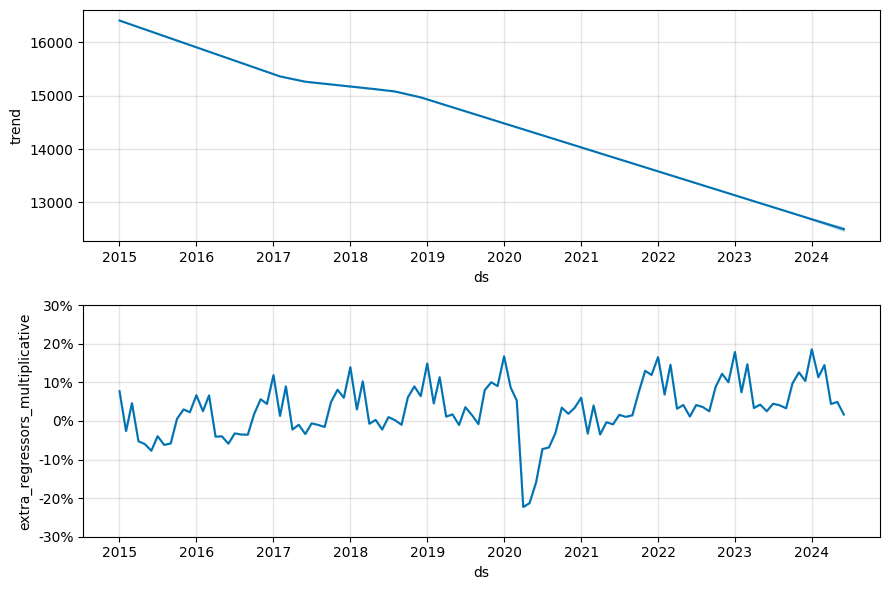

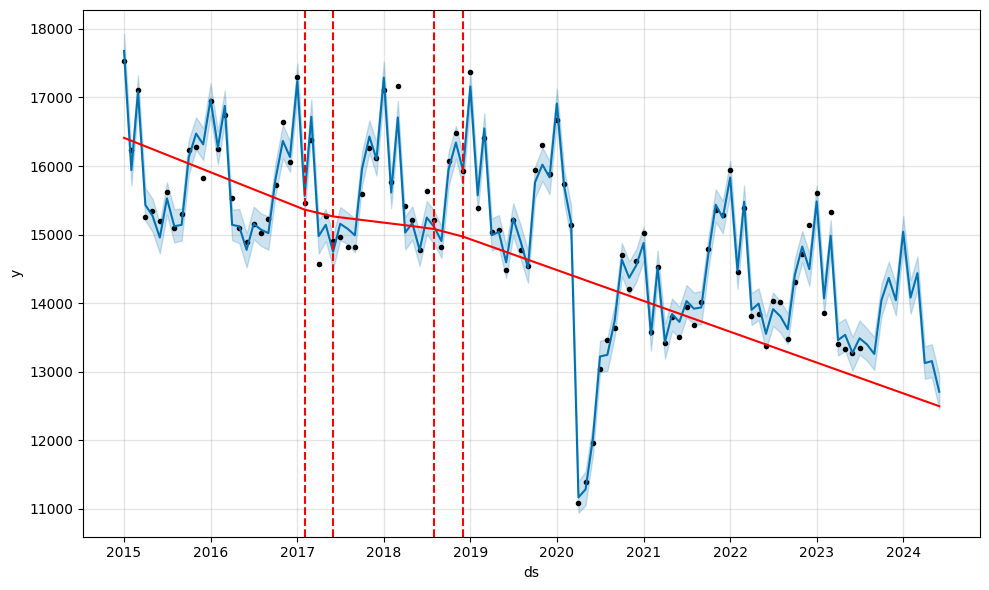

In [9]:
# Plotting the model's components and forecast including Backcast
best_model = model_from_dict(trials.best_trial['result']['prophet_dict'])
forecast = best_model.predict(future_df)
fig = best_model.plot_components(forecast)
plt.show()
fig = best_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), best_model, forecast)
plt.show()

## Prophet() Formulas, components, etc. understanding

### Looking into the components within the Prophet Python Object

In [21]:
### Parameters of the best model (Look for definitions in PPT)
# lp >> Log posterior density of the model parameters.
# k >> Growth rate parameter (slope).
# m >> initial intercept.
# delta [preprocess S size] >> slope change at each changepoint.
# sigma_obs >> standard deviation of the observations.
# beta [preprocess K size] >> coefficients for seasonality, holidats, regressors.
# trend [preprocess T size] >> estimated trend at each datetime.

best_model = model_from_dict(trials.best_trial['result']['prophet_dict'])
best_model.granularity = granularity[0]
forecast = best_model.predict(future_df)
print([x for x in best_model.params])
[best_model.params[x].size for x in best_model.params]

['lp__', 'k', 'm', 'delta', 'sigma_obs', 'beta', 'trend']


[1, 1, 1, 25, 1, 19, 103]

In [22]:
# Default forecast DataFrame
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,abnormal,abnormal_lower,abnormal_upper,covid_1,covid_1_lower,covid_1_upper,covid_2,covid_2_lower,covid_2_upper,covid_3,covid_3_lower,covid_3_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,gdp,gdp_lower,gdp_upper,is_apr,is_apr_lower,is_apr_upper,is_aug,is_aug_lower,is_aug_upper,is_dec,is_dec_lower,is_dec_upper,is_feb,is_feb_lower,is_feb_upper,is_jan,is_jan_lower,is_jan_upper,is_jul,is_jul_lower,is_jul_upper,is_jun,is_jun_lower,is_jun_upper,is_leap,is_leap_lower,is_leap_upper,is_mar,is_mar_lower,is_mar_upper,is_may,is_may_lower,is_may_upper,is_nov,is_nov_lower,is_nov_upper,is_oct,is_oct_lower,is_oct_upper,is_sep,is_sep_lower,is_sep_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekdays,weekdays_lower,weekdays_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2015-01-01,16411.191278,17442.207294,17914.594541,16411.191278,16411.191278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077263,0.077263,0.077263,-0.049128,-0.049128,-0.049128,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.125317,0.125317,0.125317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077263,0.077263,0.077263,0.001074,0.001074,0.001074,0.0,0.0,0.0,17679.172937
1,2015-02-01,16368.562852,15705.136613,16156.897450,16368.562852,16368.562852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.026176,-0.026176,-0.026176,-0.046532,-0.046532,-0.046532,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.027186,0.027186,0.027186,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.026176,-0.026176,-0.026176,-0.006830,-0.006830,-0.006830,0.0,0.0,0.0,15940.094031
2,2015-03-01,16330.059757,16840.712576,17314.114929,16330.059757,16330.059757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046239,0.046239,0.046239,-0.045978,-0.045978,-0.045978,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091143,0.091143,0.091143,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046239,0.046239,0.046239,0.001074,0.001074,0.001074,0.0,0.0,0.0,17085.150543
3,2015-04-01,16287.431331,15201.726076,15664.513285,16287.431331,16287.431331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.052563,-0.052563,-0.052563,-0.040939,-0.040939,-0.040939,-0.012699,-0.012699,-0.012699,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.052563,-0.052563,-0.052563,0.001074,0.001074,0.001074,0.0,0.0,0.0,15431.317620
4,2015-05-01,16246.178015,15037.493438,15516.156468,16246.178015,16246.178015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.059766,-0.059766,-0.059766,-0.043257,-0.043257,-0.043257,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.013631,-0.013631,-0.013631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.059766,-0.059766,-0.059766,-0.002878,-0.002878,-0.002878,0.0,0.0,0.0,15275.204093


In [23]:
# 1 for each coefficient
# There are 3 columns grouping holidays, regressors and all terms: holidays, extra_regressors_multiplicative, multiplicative_terms.
# Dropping them, the sum of 1s if beta [preprocess K size]

components = model.train_component_cols
print(components.drop(columns=['extra_regressors_multiplicative', 'multiplicative_terms']).sum().sum())
components.drop(columns=['extra_regressors_multiplicative', 'multiplicative_terms']).T.sum(axis=1)

19


component
abnormal          1
covid_1           1
covid_2           1
covid_3           1
gdp               1
is_apr            1
is_aug            1
is_dec            1
is_feb            1
is_jan            1
is_jul            1
is_jun            1
is_leap           1
is_mar            1
is_may            1
is_nov            1
is_oct            1
is_sep            1
weekdays          1
additive_terms    0
dtype: int64

In [24]:
# Coefficients and values of the extra_regressors
regressor_coefficients(best_model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,gdp,multiplicative,96.871790,0.009475,0.009475,0.009475
1,abnormal,multiplicative,0.000000,-0.021283,-0.021283,-0.021283
2,covid_1,multiplicative,0.000000,-0.022284,-0.022284,-0.022284
3,covid_2,multiplicative,0.000000,0.024005,0.024005,0.024005
4,covid_3,multiplicative,0.000000,0.014956,0.014956,0.014956
5,is_jan,multiplicative,0.000000,0.125317,0.125317,0.125317
6,is_feb,multiplicative,0.000000,0.027186,0.027186,0.027186
7,is_leap,multiplicative,0.000000,0.032752,0.032752,0.032752
8,is_mar,multiplicative,0.000000,0.091143,0.091143,0.091143
9,is_apr,multiplicative,0.000000,-0.012699,-0.012699,-0.012699


In [25]:
# Example of the normal distribution of the extra_regressor "temperature"
print(best_model.extra_regressors['gdp'])

{'prior_scale': 8.616142444589826, 'standardize': 'auto', 'mu': 96.87179029126214, 'std': 4.9214585823062444, 'mode': 'multiplicative'}


In [26]:
# All the extra_regressors' parameters
best_model.extra_regressors

OrderedDict([('gdp',
              {'prior_scale': 8.616142444589826,
               'standardize': 'auto',
               'mu': 96.87179029126214,
               'std': 4.9214585823062444,
               'mode': 'multiplicative'}),
             ('abnormal',
              {'prior_scale': 4.512231897145856,
               'standardize': 'auto',
               'mu': 0.0,
               'std': 1.0,
               'mode': 'multiplicative'}),
             ('covid_1',
              {'prior_scale': 4.564931422111742,
               'standardize': 'auto',
               'mu': 0.0,
               'std': 1.0,
               'mode': 'multiplicative'}),
             ('covid_2',
              {'prior_scale': 3.223827202877614,
               'standardize': 'auto',
               'mu': 0.0,
               'std': 1.0,
               'mode': 'multiplicative'}),
             ('covid_3',
              {'prior_scale': 3.9913417224267667,
               'standardize': 'auto',
               'mu': 0.0,
   

In [27]:
# Looking at the Inputs we give the model after they've been preprocessed (scaling, etc)
[
  'K', # number of variables' coefficients [BETA size in model.params].
  'S', # number of slope changes (at each changepoint) [DELTA size in model.params].
  'T', # number of estimated values of the trend component of the time series at each time point. [TREND size in model.params].
  'X', # Dataframe of TxK (each time series point and the variables coefficients as columns).
  'cap', # for logistic growth.
  's_a', # additive terms.
  's_m', # multiplicative terms.
  'sigmas', # Coefficients' prior_scales (Hyperparameters)
  't', # time.
  't_change', # value of t at changepoints.
  'tau', # changepoint prior_scale >> flexibility.
  'trend_indicator',
  'y' # standardized y values.
  ]
preprocess = best_model.preprocess(df)
preprocess

ModelInputData(T=103, S=25, K=19, tau=0.04403056987756032, trend_indicator=0, y=0      1.000000
1      0.925868
2      0.975386
3      0.869632
4      0.874737
         ...   
98     0.874094
99     0.764263
100    0.760053
101    0.757062
102    0.760790
Name: y_scaled, Length: 103, dtype: float64, t=0      0.000000
1      0.009990
2      0.019014
3      0.029004
4      0.038672
         ...   
98     0.960683
99     0.970674
100    0.980342
101    0.990332
102    1.000000
Name: t, Length: 103, dtype: float64, cap=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), t_change=array([

In [28]:
# How the model parameters will be initialized under the number of regressors we are utilising:
print(best_model.calculate_initial_params(num_total_regressors=preprocess.K))

ModelParams(k=-0.23921032621128802, m=1.0, delta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), beta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), sigma_obs=1.0)


In [29]:
## Saving model:
with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(best_model))  # Save model

In [30]:
## Reading model:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

## Post-processing, graphs showing results

In [20]:
# Checking what are the input parameters and priors of the best model:
utils.hyper_params_df(trials)

,abnormal,changepoint_prior_scale,changepoint_range,covid_1,covid_2,covid_3,gdp,is_apr,is_aug,is_dec,is_feb,is_jan,is_jul,is_jun,is_leap,is_mar,is_may,is_nov,is_oct,is_sep,weekdays,cross_val_mape,cutoff_points,horizon_days,hopt_algorithm,max_iters,random_state,model_sector,model_granularity,model_mape,model_mdape,training_datetime
0,4.512232,0.044031,0.887465,4.564931,3.223827,3.991342,8.616142,0.480708,0.013709,0.030417,0.042962,0.494942,0.242092,0.162,0.357779,0.056898,0.383928,0.325871,0.441963,0.310059,0.406828,0.055307,10,366,hyperopt.tpe,1,Generator(PCG64),Non-domestic,Monthly,0.055307,0.017437,2024-10-10 15:13:07.537749


In [31]:
# Getting well formatted forecasts, etc.
best_model.forecast = forecast
best_model.full_forecast = utils.full_forecast_df(best_model, future=future_df, forecast=best_model.forecast)
best_model.reduced_forecast = utils.reduced_forecast_df(best_model, best_model.full_forecast)

In [32]:
best_model.full_forecast

,ds,y,sector,nominal_gdp,nominal_abnormal,nominal_covid_1,nominal_covid_2,nominal_covid_3,nominal_is_jan,nominal_is_feb,nominal_is_leap,nominal_is_mar,nominal_is_apr,nominal_is_may,nominal_is_jun,nominal_is_jul,nominal_is_aug,nominal_is_sep,nominal_is_oct,nominal_is_nov,nominal_is_dec,nominal_weekdays,trend,yhat,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,additive_terms,gdp,abnormal,covid_1,covid_2,covid_3,is_jan,is_feb,is_leap,is_mar,is_apr,is_may,is_jun,is_jul,is_aug,is_sep,is_oct,is_nov,is_dec,weekdays,yearly,externalities,residual,error_percentage,yhat_detrended,training_datetime
0,2015-01-01,17535.797012,Non-domestic,91.687000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,22,16411.191278,17679.172937,17442.207294,17914.594541,16411.191278,16411.191278,0.077263,0.0,-0.049128,0.0,0.0,0.0,0.0,0.125317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001074,0.126391,0.0,143.375925,0.008176,1.091608,2024-10-10 15:18:41.897603
1,2015-02-01,16235.838323,Non-domestic,91.961000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,20,16368.562852,15940.094031,15705.136613,16156.897450,16368.562852,16368.562852,-0.026176,0.0,-0.046532,0.0,0.0,0.0,0.0,0.000000,0.027186,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.006830,0.020356,0.0,-295.744293,-0.018216,0.987069,2024-10-10 15:18:41.897603
2,2015-03-01,17104.171944,Non-domestic,92.019500,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,22,16330.059757,17085.150543,16840.712576,17314.114929,16330.059757,16330.059757,0.046239,0.0,-0.045978,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.091143,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001074,0.092217,0.0,-19.021401,-0.001112,1.060260,2024-10-10 15:18:41.897603
3,2015-04-01,15249.697840,Non-domestic,92.551300,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,22,16287.431331,15431.317620,15201.726076,15664.513285,16287.431331,16287.431331,-0.052563,0.0,-0.040939,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.012699,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001074,-0.011624,0.0,181.619780,0.011910,0.961755,2024-10-10 15:18:41.897603
4,2015-05-01,15339.201789,Non-domestic,92.306600,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,21,16246.178015,15275.204093,15037.493438,15516.156468,16246.178015,16246.178015,-0.059766,0.0,-0.043257,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.013631,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.002878,-0.016509,0.0,-63.997697,-0.004172,0.955065,2024-10-10 15:18:41.897603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2024-02-01,NaN,Non-domestic,102.826902,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,21,12645.356220,14080.445142,13847.177500,14329.480972,12629.492128,12664.531506,0.113487,0.0,0.056427,0.0,0.0,0.0,0.0,0.000000,0.027186,0.032752,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.002878,0.057060,0.0,NaN,NaN,1.131466,2024-10-10 15:18:41.897603
110,2024-03-01,NaN,Non-domestic,102.849994,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,21,12609.648219,14436.921579,14199.959379,14675.130650,12589.397896,12632.372167,0.144911,0.0,0.056646,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.091143,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.002878,0.088265,0.0,NaN,NaN,1.161708,2024-10-10 15:18:41.897603
111,2024-04-01,NaN,Non-domestic,102.746683,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,22,12571.477598,13125.162216,12896.289706,13351.617989,12546.808529,12599.804353,0.044043,0.0,0.055667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.012699,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001074,-0.011624,0.0,NaN,NaN,1.059669,2024-10-10 15:18:41.897603
112,2024-05-01,NaN,Non-domestic,103.000126,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,23,12534.538287,13154.549468,12906.705072,13394.698375,12505.911256,12568.947403,0.049464,0.0,0.058069,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.013631,0.00000

In [33]:
best_model.reduced_forecast

,ds,y,sector,nominal_gdp,nominal_weekdays,trend,yhat,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,additive_terms,gdp,is_leap,weekdays,yearly,externalities,residual,error_percentage,yhat_detrended,training_datetime
0,2015-01-01,17535.797012,Non-domestic,91.687000,22,16411.191278,17679.172937,17442.207294,17914.594541,16411.191278,16411.191278,0.077263,0.0,-0.049128,0.000000,0.001074,0.126391,0.0,143.375925,0.008176,1.091608,2024-10-10 15:18:41.897603
1,2015-02-01,16235.838323,Non-domestic,91.961000,20,16368.562852,15940.094031,15705.136613,16156.897450,16368.562852,16368.562852,-0.026176,0.0,-0.046532,0.000000,-0.006830,0.020356,0.0,-295.744293,-0.018216,0.987069,2024-10-10 15:18:41.897603
2,2015-03-01,17104.171944,Non-domestic,92.019500,22,16330.059757,17085.150543,16840.712576,17314.114929,16330.059757,16330.059757,0.046239,0.0,-0.045978,0.000000,0.001074,0.092217,0.0,-19.021401,-0.001112,1.060260,2024-10-10 15:18:41.897603
3,2015-04-01,15249.697840,Non-domestic,92.551300,22,16287.431331,15431.317620,15201.726076,15664.513285,16287.431331,16287.431331,-0.052563,0.0,-0.040939,0.000000,0.001074,-0.011624,0.0,181.619780,0.011910,0.961755,2024-10-10 15:18:41.897603
4,2015-05-01,15339.201789,Non-domestic,92.306600,21,16246.178015,15275.204093,15037.493438,15516.156468,16246.178015,16246.178015,-0.059766,0.0,-0.043257,0.000000,-0.002878,-0.016509,0.0,-63.997697,-0.004172,0.955065,2024-10-10 15:18:41.897603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2024-02-01,NaN,Non-domestic,102.826902,21,12645.356220,14080.445142,13847.177500,14329.480972,12629.492128,12664.531506,0.113487,0.0,0.056427,0.032752,-0.002878,0.057060,0.0,NaN,NaN,1.131466,2024-10-10 15:18:41.897603
110,2024-03-01,NaN,Non-domestic,102.849994,21,12609.648219,14436.921579,14199.959379,14675.130650,12589.397896,12632.372167,0.144911,0.0,0.056646,0.000000,-0.002878,0.088265,0.0,NaN,NaN,1.161708,2024-10-10 15:18:41.897603
111,2024-04-01,NaN,Non-domestic,102.746683,22,12571.477598,13125.162216,12896.289706,13351.617989,12546.808529,12599.804353,0.044043,0.0,0.055667,0.000000,0.001074,-0.011624,0.0,NaN,NaN,1.059669,2024-10-10 15:18:41.897603
112,2024-05-01,NaN,Non-domestic,103.000126,23,12534.538287,13154.549468,12906.705072,13394.698375,12505.911256,12568.947403,0.049464,0.0,0.058069,0.000000,0.005027,-0.008604,0.0,NaN,NaN,1.065698,2024-10-10 15:18:41.897603


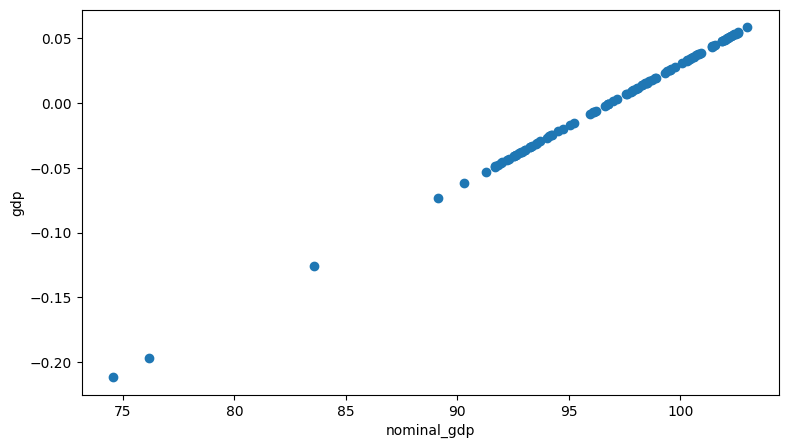

In [34]:
# Plotting Weather Regressors
fig = utils.plot_regressors_linearity(best_model)

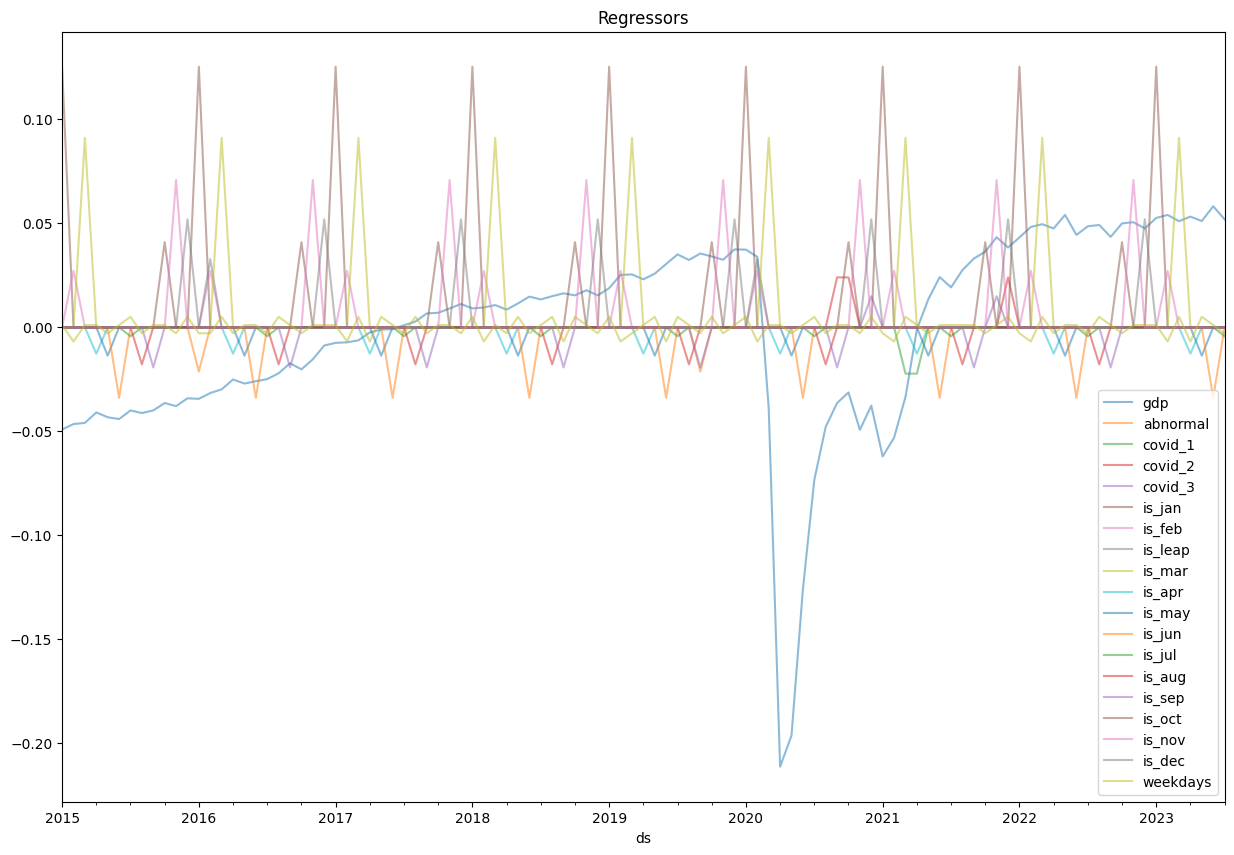

In [35]:
# Plotting Regressors' weights throughout time
fig2 = utils.plot_regressors(best_model)

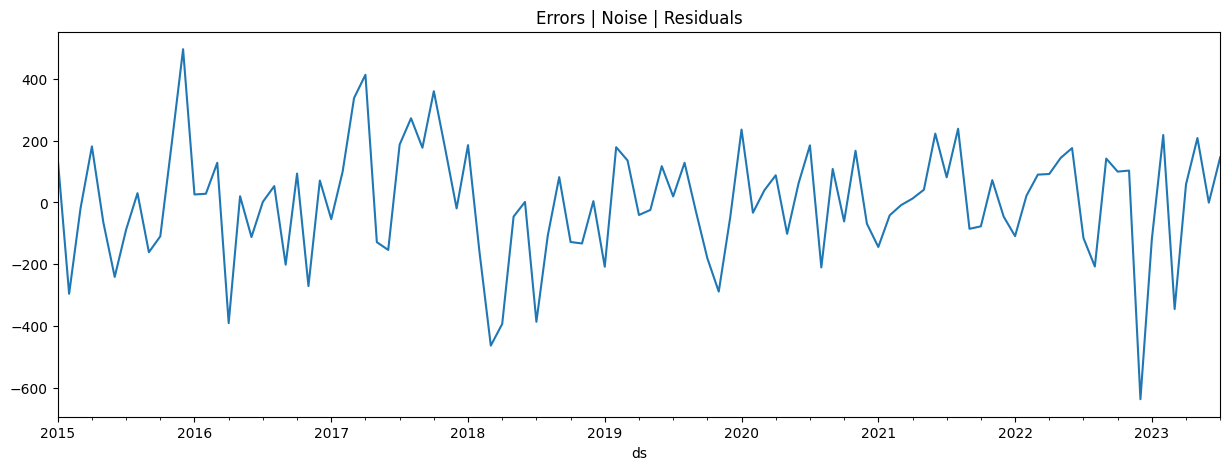

In [36]:
# Plotting Model's Noise / Errors
fig3 = utils.plot_noise_ts(best_model)

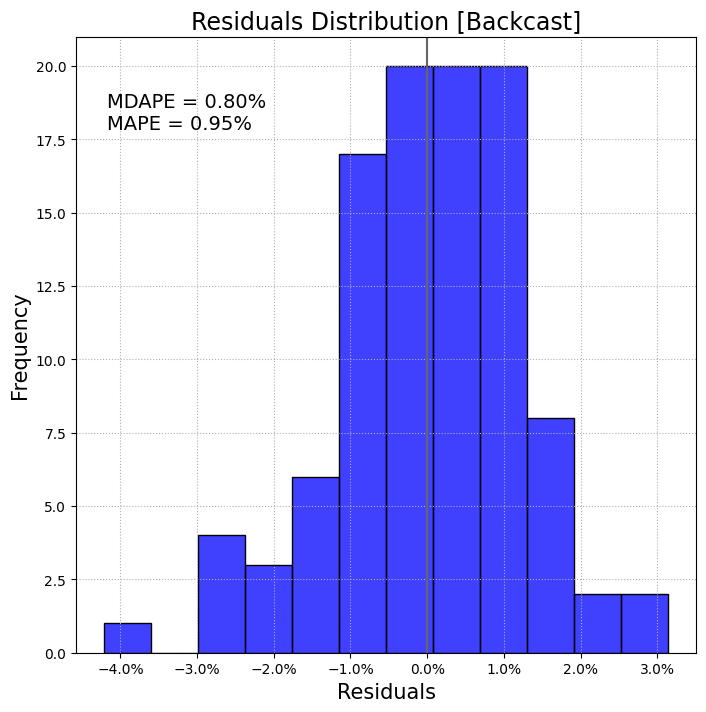

In [37]:
# Histogram of Model's Errors
fig4 = utils.plot_error_hist(best_model)

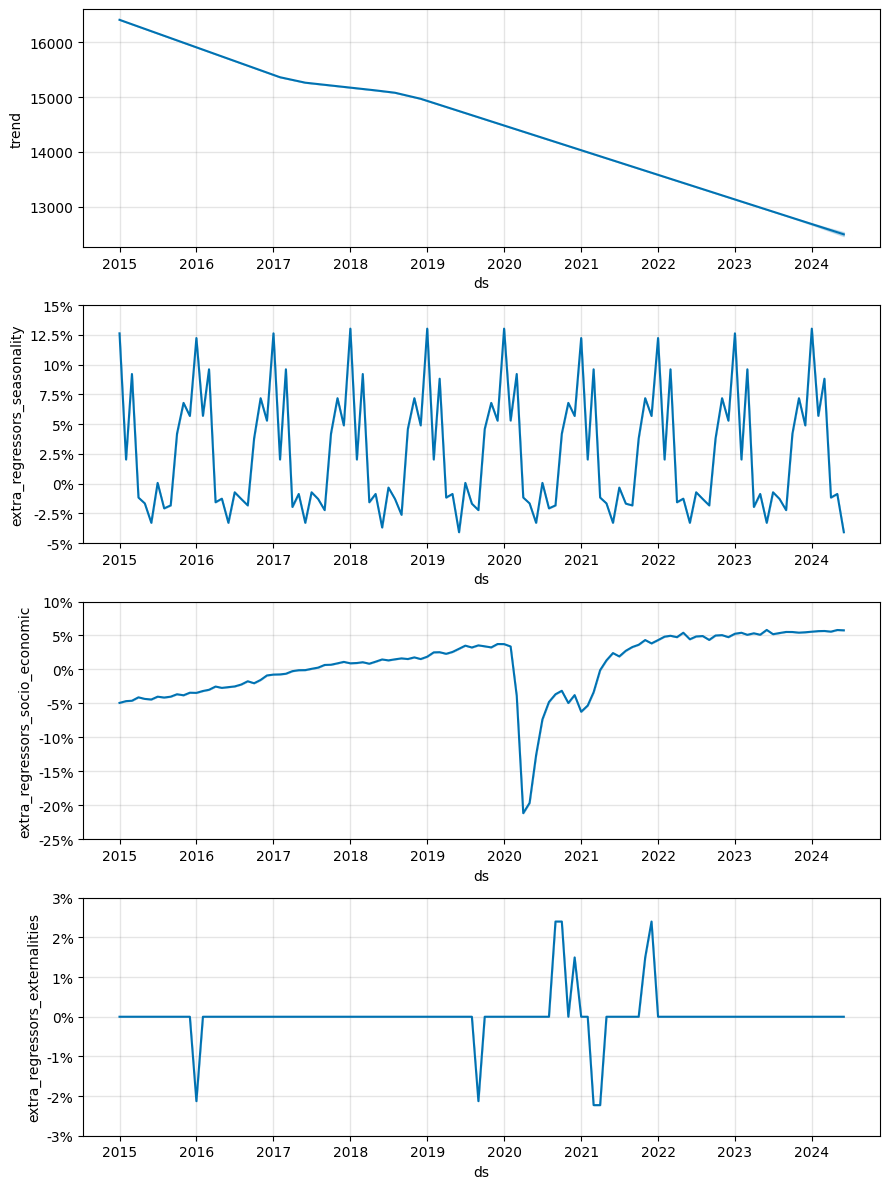

In [38]:
# Plotting components Tidely 
fig5 = utils.plot_base_components(best_model)

In [39]:
best_model.reduced_forecast.to_parquet(os.path.join(utils.outputs_folder, 'monthly', f"{category}_{granularity}_reduced_forecast.parquet"))
best_model.full_forecast.to_parquet(os.path.join(utils.outputs_folder, 'monthly', f"{category}_{granularity}_full_forecast.parquet"))

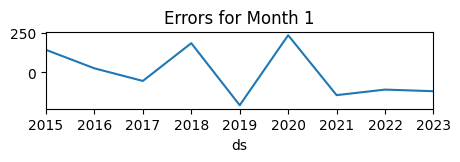

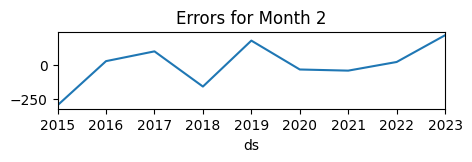

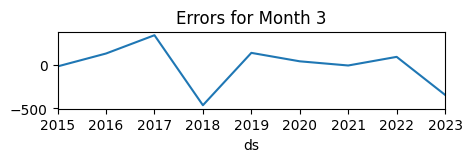

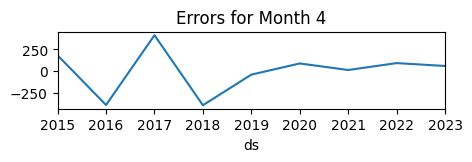

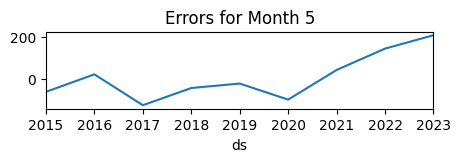

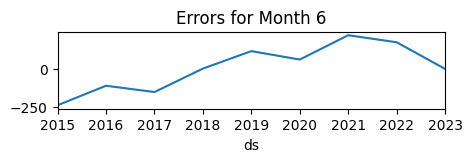

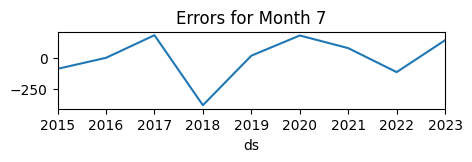

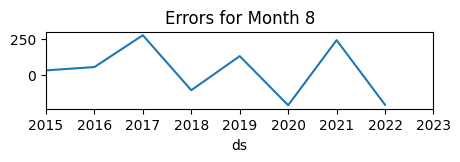

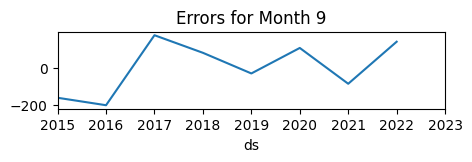

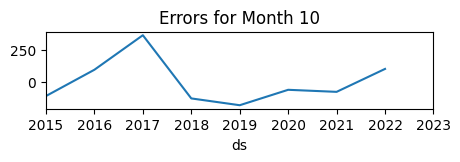

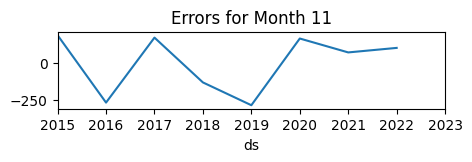

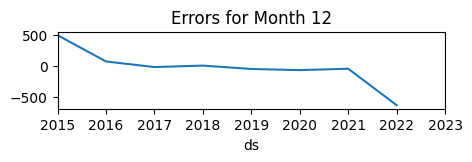

In [40]:
# Exploring noise by DOW:
# There is clearly more signals that can be retrieved from the model.

for month in range(1,13):

  error_ax = best_model.full_forecast[(best_model.full_forecast['ds'] >= '2015-01-01') & (best_model.full_forecast['ds'].dt.month == month)].dropna().set_index('ds')['residual'].plot(figsize=(
      5, 1), title=f'Errors for Month {month}', xlim=([best_model.history['ds'].min(), best_model.history['ds'].max()]))
  error_fig = error_ax.get_figure()
  plt.show()
